In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import zipfile


'''
Data prep and feature mapping
'''
# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"




Features with zero variance after filtering: 0


Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Best parameters found: {'estimator': SVC(random_state=42), 'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'select_k__k': 50}
Best cross-validation score: 0.959


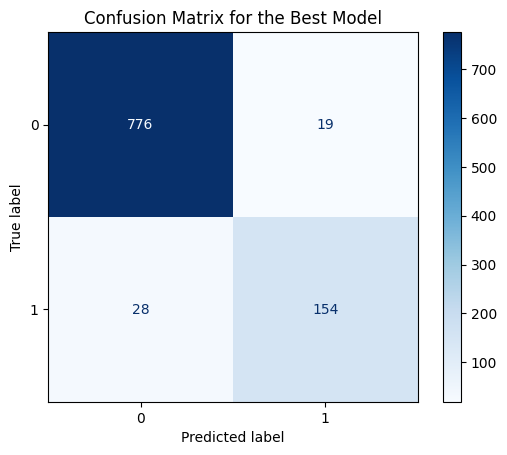

In [33]:
''' Pipeline implementation for Naive bayes and random forests'''

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', GaussianNB())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 20, 30, 40, 50],  # May need adjuisting  100, 200, 300
        'estimator': [GaussianNB()],
        'estimator__var_smoothing': np.logspace(0, -9, num=100)
    },
    {
        'select_k__k': [10, 20, 30, 40, 50],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 20, 30, 40, 50],  # May need as needed  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    }
]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

# Calculate accuracy and other metrics as needed
#print("Accuracy on test set:", accuracy_score(Y_test, Y_pred))
#print("F1 Score on test set:", f1_score(Y_test, Y_pred, average='macro'))
#print("Classification Report:\n", classification_report(Y_test, Y_pred))

# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for the Best Model')
plt.show()




Most selected KO terms for predicting oxygen trait in hierchical manner (F score):
Index(['K01589', 'K00164', 'K01772', 'K05919', 'K01599', 'K00254', 'K02259',
       'K04070', 'K02257', 'K01163', 'K13628', 'K02823', 'K07138', 'K01677',
       'K16951', 'K00940', 'K11358', 'K17828', 'K00176', 'K01679', 'K03644',
       'K09157', 'K00674', 'K07166', 'K01902', 'K03737', 'K01903', 'K07146',
       'K03635', 'K22405', 'K00177', 'K18330', 'K03575', 'K03801', 'K06980',
       'K01633', 'K00241', 'K02276', 'K00658', 'K06891', 'K00390', 'K15635',
       'K07735', 'K10563', 'K03118', 'K01698', 'K01719', 'K03660', 'K00610',
       'K00533'],
      dtype='object', name='KO')


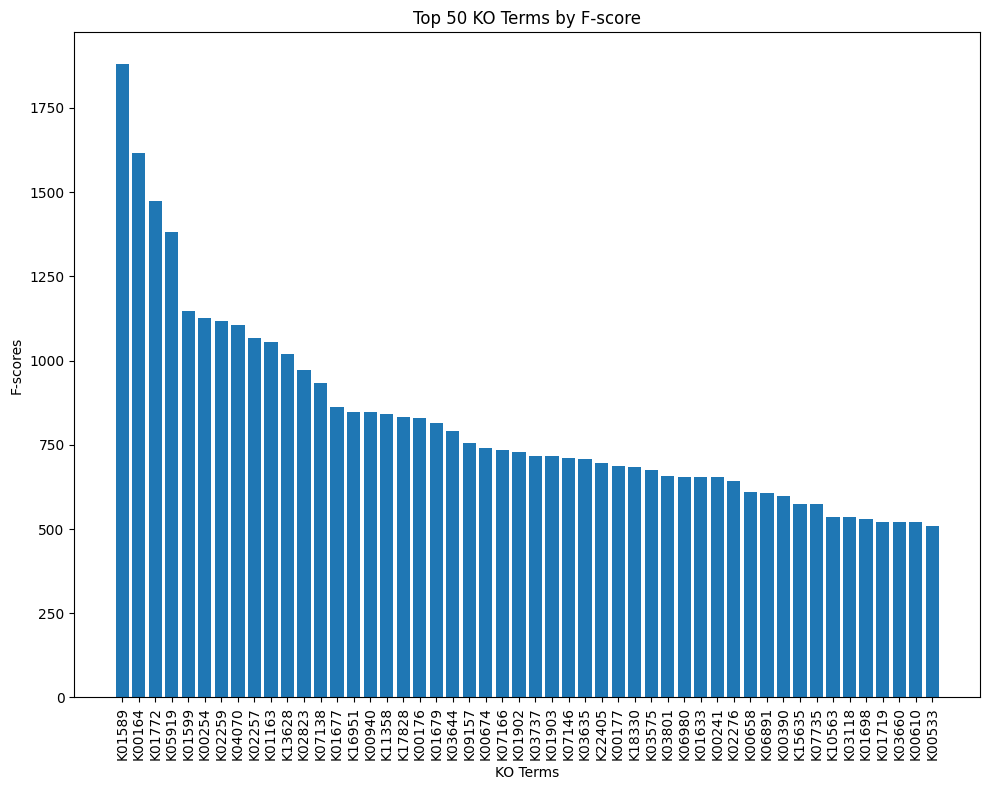

In [34]:
''' Finding best traits '''

# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=50)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

''' Plot for visualizing distribution and importance of best traits'''

# bar plot shows distribution of F-scores for the selected features
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_features)), sorted_scores)
plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
plt.xlabel('KO Terms')
plt.ylabel('F-scores')
plt.title('Top 50 KO Terms by F-score')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [36]:
''' K values versus f1 score plot'''


# Define the range of `k` values to explore
k_values = range(1, 300, 5)  # Range of steps

# Define estimators to compare
estimators = {
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines' : SVC()
}

# Prepare to store results
results = {name: [] for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")  # Debug print
    # Loop over each `k` value
    for k in k_values:
        print(f"Testing with k={k}")  # Debug print
        # Define the pipeline for the current estimator
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        
        # Perform cross-validation using StratifiedKFold
        cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)
        
        # Store the mean F1 score for this `k`
        results[name].append(cv_scores.mean())

# For debugging print(results)


Processing estimator: GaussianNB
Testing with k=1
Testing with k=6
Testing with k=11
Testing with k=16
Testing with k=21
Testing with k=26
Testing with k=31
Testing with k=36
Testing with k=41
Testing with k=46
Testing with k=51
Testing with k=56
Testing with k=61
Testing with k=66
Testing with k=71
Testing with k=76
Testing with k=81
Testing with k=86
Testing with k=91
Testing with k=96
Testing with k=101
Testing with k=106
Testing with k=111
Testing with k=116
Testing with k=121
Testing with k=126
Testing with k=131
Testing with k=136
Testing with k=141
Testing with k=146
Testing with k=151
Testing with k=156
Testing with k=161
Testing with k=166
Testing with k=171
Testing with k=176
Testing with k=181
Testing with k=186
Testing with k=191
Testing with k=196
Testing with k=201
Testing with k=206
Testing with k=211
Testing with k=216
Testing with k=221
Testing with k=226
Testing with k=231
Testing with k=236
Testing with k=241
Testing with k=246
Testing with k=251
Testing with k=256
T

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


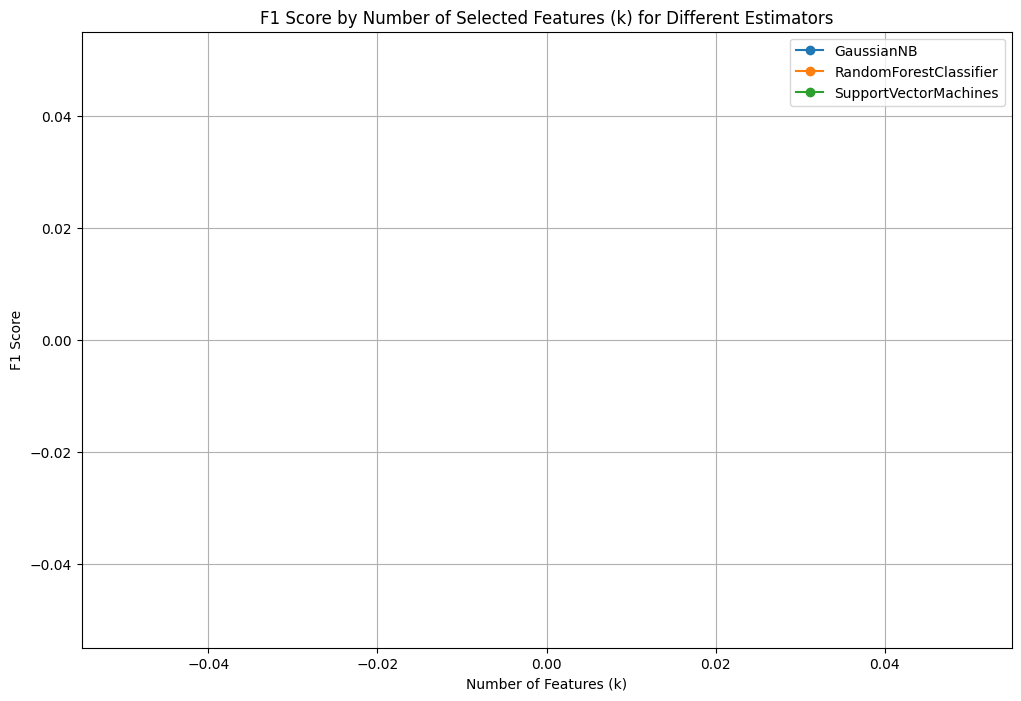

Highest overall F1 score: 0.00 for  with k=None


In [39]:
''' Plot for F1 vs K features '''

# Plotting the results for each estimator
plt.figure(figsize=(12, 8))
highest_overall_f1_score = 0  # Track the highest F1 score among all estimators
best_k_overall = None
best_estimator_name = ""

for name, scores in results.items():
    k_values_list = list(k_values)  # Convert range to list for indexing
    max_f1_score_index = scores.index(max(scores))  # Index of the highest F1 score for this estimator
    max_f1_score = scores[max_f1_score_index]  # The highest F1 score
    best_k = k_values_list[max_f1_score_index]  # `k` value for the highest F1 score
    
    # Update overall highest F1 score if this estimator's best is higher
    if max_f1_score > highest_overall_f1_score:
        highest_overall_f1_score = max_f1_score
        best_k_overall = best_k
        best_estimator_name = name

    # Plot F1 scores
    plt.plot(k_values_list, scores, marker='o', linestyle='-', label=name)
    
    # Highlight the point with the highest F1 score
    plt.scatter([best_k], [max_f1_score], color='red')  # Highlight with red color
    plt.text(best_k, max_f1_score, f"{max_f1_score:.2f}", fontsize=9, verticalalignment='bottom')

plt.title('F1 Score by Number of Selected Features (k) for Different Estimators')
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Print the highest F1 score among all estimators and the corresponding `k` value
print(f"Highest overall F1 score: {highest_overall_f1_score:.2f} for {best_estimator_name} with k={best_k_overall}")


In [38]:
''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")



Class distribution in Y_train:
 aerobic      1909
anaerobic     370
Name: count, dtype: int64
Unique labels in Y_train: ['aerobic' 'anaerobic']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279
